# Predicting The Office episode ratings to advise NBC Universal on a reunion episode
#### Machine Learning in Python - Group Project 1
*Data Scientist Contractors: Luke Appleby, Josep Garcia-Reyero, Tom Birkbeck, Adam Dunajski*

In this report, we explore what makes a great episode of The Office, NBC Universal's widely-regarded situational comedy about the office life of a paper manufacturer. 

This is achieved through a machine learning model which predicts the rating of the episode based on a number of episode characteristics - such as whether the episode features a cold open, and how many spoken lines are in it. 

We use this model to give a reccomendation on episode features which will **maximise IMBD rating** for the episode.

The report is formatted in the style of an interactive workbook in which the client (NBC Universal) can step through cells of code interspersed with explanation of model choices and mathematical background.

### Table of Contents

0.  Predicting The Office episode ratings to advise NBC Universal on a reunion episode
1. Introduction    
    1.1 Model and conclusions overview/precis    
    1.2 Data sources used    
    1.3 General code setup       
2. Exploratory Data Analysis and Feature Engineering    
    2.1 **<span style="color:red">SECTION</span>**    
    2.2 **<span style="color:red">SECTION</span>**     
    2.3 **<span style="color:red">SECTION</span>**    
    2.4 **<span style="color:red">SECTION</span>**    
3. Model fitting and tuning    
    3.1 **<span style="color:red">SECTION</span>**    
    3.2 **<span style="color:red">SECTION</span>**    
    3.3 **<span style="color:red">SECTION</span>**    
4. Discussion and Conclusions    
    4.1 **<span style="color:red">SECTION</span>**    
    4.2 **<span style="color:red">SECTION</span>**    
    4.3 **<span style="color:red">SECTION</span>**    
5. References

## 1 Introduction
In this section, we give an abstract of our modelling approach and truncated results, intended for senior managers who are short on time to view. 

We then discuss our data sources and set-up of the code environment for the model.

## 1.1 Model and conclusions overview/precis

After comparing a number of models, we found a **<span style="color:red">[WHICH MODEL DID WE FIND BEST]</span>** model was the best to fit to the data. It had a prediction accuracy of **<span style="color:red">[WHAT WAS ITS ACCURACY]</span>**, which is very high.

The model indicates that strong postive correlants of episodic IMBD rating are **<span style="color:red">[WHAT WERE THE CORRELANTS]</span>**, therefore, we advise NBC Universal to apply the following list of reccomendations when writing the reunion episode.


<span style="color:red">[WHAT WERE THE CORRELANTS]
* COLD OPEN
* OTHER THINGS
    </span>

## 1.2 Data sources
Our primary data source was the office episode ratings dataset the_office.csv (Evkaya, 2023).

We also explored the binary variable of whether or not the episode featured a cold-open, where the setting and premise of the episode is introduced in media res at the beginning of the episode, before the credits. This data was web-scraped from Dunderpedia: The Office Encyclopedia (Various authors, 2023a) and included in our dataset after an extensive cleaning process.

Furthermore, we explored two running themes of the episodes themselves: these are how many times Jim plays a prank in an episode, and whether or not the episode is contains key moments for the development of one of the series' key romantic relationships between Jim and Pam. The first of these was also sourced by web-scrapoing Dunderpedia: The Office Encyclopedia and subjecting the data to an extensive cleaning process (Various authors, 2023b), whilst the second was scraped and cleaned from a CinemaBlend article (West, 2020).

In total, this gave us four data sources:
* Initial dataset
* Dunderpedia article on cold opens
* Dunderpedia article on Jim's pranks
* CinemaBlend article on Jim and Pam's relationship.

## 1.3 General Setup
The following cell makes necessary package imports and sets some parameters for plotting.

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

The next four cells read and join the data from our four sources. We start with the_office.csv as as the base, and treat other data as additional, cleaning, transforming and appending it.

In [2]:
# Read CSV file data
data = pd.read_csv("the_office.csv")
data_explore = data.copy()

In [3]:
with open('MLP_cold_opens.txt', 'r') as file:
    new_data = file.read().replace('\n', '')

x = new_data.split(")")
hots = []
for i in range(len(x)):
    if x[i][0:4] == 'None':
        hots.append(x[i][7:-1])
    elif x[i][0:8] == 'Season 1' and x[i][8:12] == 'None':
        hots.append(x[i][14:])
    elif x[i][0:6] == 'Season' and x[i][8:12] == 'None':
        hots.append(x[i][15:-1])

hots_df = pd.DataFrame (hots, columns = ['episode_name'])
hots_df['cold_open'] = np.zeros(12).astype(int)
hots_df = hots_df.replace(to_replace = 'Weight Loss', value = 'Weight Loss (Parts 1&2)')
data_ = pd.merge(data, hots_df, on='episode_name', how='left')
data_['cold_open'] = data_['cold_open'].fillna(1)

data_.loc[data_['cold_open'] == 1]

data = data_

In [4]:
with open('MLP_jim_pranks.txt', 'r') as file:
    pranks_str = file.read().replace('\n', '')
    
x0 = pranks_str.split('(')
j = 0
for i in x0:
    x0[j] = i.split(')')
    j+=1
j = 0
for i in x0:
    x0[j] = i[0]
    j +=1
for i in range(len(x0)):
    x0[i] = x0[i][1:-1]


names = data['episode_name']

names = names.replace(to_replace = 'E-Mail Surveilance', value = 'Email Surveillance')
names = names.replace(to_replace = 'A Benihana Christmas ', value = 'A Benihana Christmas')
names = names.replace(to_replace = 'The Job ', value = 'The Job', regex = True)
names = names.replace(to_replace = 'Launch Party ', value = 'Launch Party', regex = True)
names = names.replace(to_replace = 'Goodbye, Toby ', value = 'Goodbye Toby', regex = True)
names = names.replace(to_replace = 'Niagara ', value = 'Niagara', regex = True)
names = names.replace(to_replace = 'The Cover', value = 'The Cover-Up', regex = True)
names = names.replace(to_replace = 'Classy Christmas ', value = 'Classy Christmas', regex = True)
names = names.replace(to_replace = 'Dwight K. Schrute, (Acting) Manager', value = 'Dwight K. Schrute,')
names = np.array(names)

j = 0
for i in names:
    if i[-11:] == '(Parts 1&2)':
        names[j] = i[:-11]
    elif i[-8:] == '(Part 1)' or i[-8:] == '(Part 2)':
        names[j] = i[:-8]
    j +=1
        
pranks = []
for i in names:
    #print(x0.count(i))
    pranks.append(x0.count(i))
#     a += x0.count(i)

data['jim_pranks'] = pranks

data
data_explore = data.copy()

In [5]:
with open('jim_and_pam_key_episodes.txt', 'r') as file:
    text = file.read()
    
start = 0
pam_jim_episodes = []

while True:
    start = text.find('(', start) + 1
    if start == 0:
        break
        
    end = text.find(')', start)
    between_brackets = text[start:end]
    
    if any(char.isdigit() for char in between_brackets):
        season = int(between_brackets[1])
        after_E_string = between_brackets[between_brackets.find('E')+1:]
        
        if '/' in after_E_string:
            pam_jim_episodes.append([season, int(after_E_string[:after_E_string.find('/')])])
            pam_jim_episodes.append([season, int(after_E_string[after_E_string.find('/')+1:])])
        
        else:
            pam_jim_episodes.append([season, int(after_E_string)])
        
    start = end + 1
    
    
def is_jim_and_pam_key_episode(row, key_episodes):
    season, episode = row['season'], row['episode']
    return int([season, episode] in key_episodes)

data_explore['pam_and_jim_key_episode'] = data_explore.apply(
    lambda row: is_jim_and_pam_key_episode(row, pam_jim_episodes), axis=1
)

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In the cell below, we show the data frame created from our four sources without any modification, alongside summary statistics. Additionally, we check for NA and duplicated values in the data, finding none - an important step in veryifying the data we collected.  

In [6]:
print ("Columns in the df are:")
print (data_explore.columns.tolist(), "\n")

dup_num = pd.DataFrame(data_explore).duplicated().sum()
print("There are {} duplicated values in the data".format(dup_num))

na_num = data_explore.isna().sum().sum()
print(f"There are {na_num} Na values in the data")

data_explore.describe()


Columns in the df are:
['season', 'episode', 'episode_name', 'director', 'writer', 'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode'] 

There are 0 duplicated values in the data
There are 0 Na values in the data


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open,jim_pranks,pam_and_jim_key_episode
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548,0.935484,0.521505,0.231183
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407,0.246333,0.901692,0.422727
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000,0.000000,0.000000,0.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000,1.000000,0.000000,0.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000,1.000000,0.000000,0.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000,1.000000,1.000000,0.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000,1.000000,8.000000,1.000000


Our summary statistics show us a few important summary points:
* There are 186 episodes in the dataset.
* The mean IMDB rating across the series was 8.25.
* The average number of Jim pranks per episode is 0.5, with a maximum of 8 in one.

In the cell below, we create a correlation heatmap between the current columns of a dataset, to give some understanding of the data. We are looking for variables with a high correlation with each other (as they may not both add a lot of value to the model) and the correlation of variables with IMDB ratings.

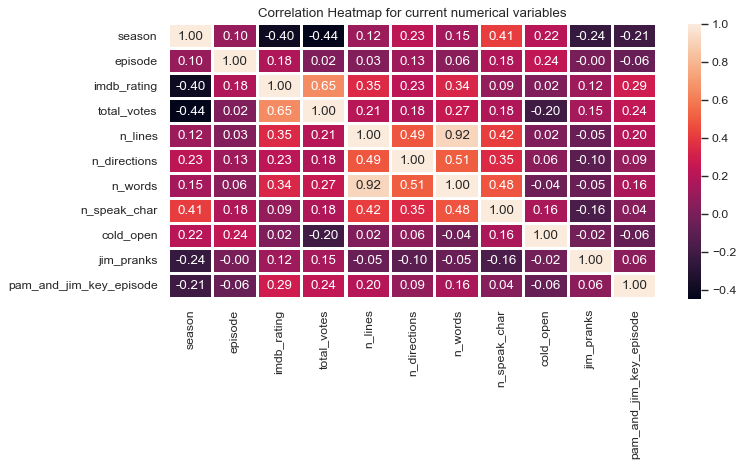

In [7]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(data_explore.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap for current numerical variables")
plt.tight_layout()
plt.show()

Some important results stand out from this matrix. We see the highest correlation on IMDB_rating is total_votes - but since we cannot predict how many people will vote, nor advise the client on how to affect this figure, we should not include it in our analyses.

Other significant correlations are season - we see that a greater season number is negatively correlated (-0.4) with IMDB rating, implying that the quality of the episodes decreased as time went on. Although our client cannot control the season of the reunion special, is is important because it tells us to look for the high-quality characteristics shared by earlier episodes and not by later episodes. 

We will first drop the episode name and episode number features because they are not relevant to the model.

In [8]:
data_explore = data_explore.drop("episode_name", axis=1)
data_explore = data_explore.drop("episode", axis=1)

print (data_explore.columns.tolist())

['season', 'director', 'writer', 'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode']


Next, we will use the variable "air_date" to create two new categorical variable features: "calendar_season", being the season (autumn, winter, spring, summer) when the episode was aired; and "air_month" being the month the episode aired. After this we drop "air_date".

In [9]:
# data['air_date'] = pd.to_datetime(data['air_date'])

# convert the 'dates' column to datetime format
data_explore['air_date'] = pd.to_datetime(data_explore['air_date'])

# create a new categorical column 'calendar_season' by assigning a category "winter", 
# "spring", "summer", "autumn" depending on the air-month.
data_explore['calendar_season'] = pd.cut(
    data_explore['air_date'].dt.month, 
    [0, 3, 6, 9, 12], 
    labels=['winter', 'spring', 'summer', 'autumn']
)

# convert calender season to string column rather than categorical column.
data_explore['calendar_season'] = data_explore['calendar_season'].astype(str)

# Create month column.
data_explore['month'] = data_explore['air_date'].dt.month

data_explore.head(5)


,season,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,cold_open,jim_pranks,pam_and_jim_key_episode,calendar_season,month
0,1,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,0.0,3,1,winter,3
1,1,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,0.0,0,0,winter,3
2,1,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,2,0,spring,4
3,1,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,1,0,spring,4
4,1,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,0.0,0,0,spring,4


In [10]:
data_explore = data_explore.drop("air_date", axis=1)
data_explore.head(5)

,season,director,writer,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,main_chars,cold_open,jim_pranks,pam_and_jim_key_episode,calendar_season,month
0,1,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,0.0,3,1,winter,3
1,1,Ken Kwapis,B.J. Novak,8.3,3566,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,0.0,0,0,winter,3
2,1,Ken Whittingham,Paul Lieberstein,7.9,2983,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,2,0,spring,4
3,1,Bryan Gordon,Michael Schur,8.1,2886,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,1,0,spring,4
4,1,Greg Daniels,Greg Daniels,8.4,3179,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,0.0,0,0,spring,4


In [11]:
list(data_explore.columns)

['season',
 'director',
 'writer',
 'imdb_rating',
 'total_votes',
 'n_lines',
 'n_directions',
 'n_words',
 'n_speak_char',
 'main_chars',
 'cold_open',
 'jim_pranks',
 'pam_and_jim_key_episode',
 'calendar_season',
 'month']

We now write a one hot encoder function to assign a binary attribute per category for the Categorical variables ("director, "writer", "calendar_season" and "main_chars"):

In [12]:
def OneHot_encoder(df, cat_variable):
    oneHot_df = df.copy()
    variable_initials = ''.join([word[0] for word in cat_variable.split("_")])

    
    unique_chars = set(';'.join(oneHot_df[cat_variable]).split(';'))

    # Create binary attributes for each unique character
    for char in unique_chars:
        oneHot_df[variable_initials+"_"+char] = oneHot_df[cat_variable].apply(lambda x: 1 if char in x else 0)
    
    
    # Drop the original main_chars column
    oneHot_df = oneHot_df.drop(columns=[cat_variable])
    
    return oneHot_df


cat_variables = ['director', 'writer', 'main_chars', 'calendar_season']

for cat_variable in cat_variables:
    data_explore = OneHot_encoder(data_explore, cat_variable)
    

data_explore.head(5)


,season,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open,jim_pranks,pam_and_jim_key_episode,...,mc_Oscar,mc_Pam,mc_Meredith,mc_Kelly,mc_Darryl,mc_Stanley,cs_autumn,cs_summer,cs_spring,cs_winter
0,1,7.6,3706,229,27,2757,15,0.0,3,1,...,1,1,0,0,0,1,0,0,0,1
1,1,8.3,3566,203,20,2808,12,0.0,0,0,...,1,1,0,1,0,1,0,0,0,1
2,1,7.9,2983,244,21,2769,13,0.0,2,0,...,1,1,1,0,0,1,0,0,1,0
3,1,8.1,2886,243,24,2939,14,0.0,1,0,...,1,1,1,0,0,1,0,0,1,0
4,1,8.4,3179,230,49,2437,18,0.0,0,0,...,1,1,0,0,1,1,0,0,1,0


In [13]:
# columns = list(data_explore.columns)
# mc_list = [columns[i] for i in range(len(columns)) if columns[i][:3] == "mc_"]
# n = len(mc_list)

In [14]:
# pairnames = []
# for i in range(n-1):
#     for j in range(i+1,n):
#         pairname = "pair_" + mc_list[i][3:] + "_"+ mc_list[j][3:]
#         pairnames.append(pairname)
#         data_explore[pairname] = ((data_explore[mc_list[i]] + data_explore[mc_list[j]])//2)

In [15]:
# corr_mat = data_explore.corr()["imdb_rating"]

# corr_array = np.zeros((n,n))
# for i in range(n-1):
#     for j in range(i+1,n):
#         pairname = "pair_" + mc_list[i][3:] + "_"+ mc_list[j][3:]
#         corr_array[i][j] = corr_mat[pairname]
#         corr_array[j][i] = corr_mat[pairname]
#     corr_array[i][i] = corr_mat[mc_list[i]]

In [16]:
# fig, axes = plt.subplots(figsize = (10,10), ncols = 1)

# mc_names = [mc_name[3:] for mc_name in mc_list]
# plt.grid(b=False)
# plt.imshow(corr_array)
# plt.colorbar()
# plt.xticks(range(n), mc_names, rotation ='vertical')
# plt.yticks(range(n), mc_names)
# plt.show()

By inspection we realised that there are some repeated directors where in some data entries the name of the director is spelled wrong. The specific cases were:

 - Charles McDougall (correct name) and Charles McDougal
 - Claire Scanlon (correct name) and Claire Scanlong 
 - Greg Daniels (correct name) and Greg Daneils
 - Ken Whittingham (correct name) and Ken Wittingham 
 - Paul Lieberstein (correct name) and Paul Lieerstein
 
Thus we now write code to remove columns with the wrong name, where we will put a 1 in the correct name column if the incorrect one had a 1 and the correct one didn't.

In [17]:
correct_names = ['d_Charles McDougall','d_Claire Scanlon','d_Greg Daniels', 'd_Ken Whittingham', 'd_Paul Lieberstein']
wrong_names = ['d_Charles McDougal','d_Claire Scanlong','d_Greg Daneils', 'd_Ken Wittingham', 'd_Paul Lieerstein']

for i, correct_name in enumerate(correct_names):
    data_explore.loc[data_explore[wrong_names[i]] == 1, correct_name] = 1
    data_explore = data_explore.drop(wrong_names[i], axis=1)
    
data_explore.head(5)

,season,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,cold_open,jim_pranks,pam_and_jim_key_episode,...,mc_Oscar,mc_Pam,mc_Meredith,mc_Kelly,mc_Darryl,mc_Stanley,cs_autumn,cs_summer,cs_spring,cs_winter
0,1,7.6,3706,229,27,2757,15,0.0,3,1,...,1,1,0,0,0,1,0,0,0,1
1,1,8.3,3566,203,20,2808,12,0.0,0,0,...,1,1,0,1,0,1,0,0,0,1
2,1,7.9,2983,244,21,2769,13,0.0,2,0,...,1,1,1,0,0,1,0,0,1,0
3,1,8.1,2886,243,24,2939,14,0.0,1,0,...,1,1,1,0,0,1,0,0,1,0
4,1,8.4,3179,230,49,2437,18,0.0,0,0,...,1,1,0,0,1,1,0,0,1,0


In [18]:
list(data_explore.columns)

['season',
 'imdb_rating',
 'total_votes',
 'n_lines',
 'n_directions',
 'n_words',
 'n_speak_char',
 'cold_open',
 'jim_pranks',
 'pam_and_jim_key_episode',
 'month',
 'd_Miguel Arteta',
 'd_Brent Forrester',
 'd_Jennifer Celotta',
 'd_Paul Lieberstein',
 'd_Jesse Peretz',
 'd_Daniel Chun',
 'd_Roger Nygard',
 'd_Ken Kwapis',
 'd_Harold Ramis',
 'd_Reginald Hudlin',
 'd_Greg Daniels',
 'd_Rainn Wilson',
 'd_B.J. Novak',
 'd_Troy Miller',
 'd_Jon Favreau',
 'd_Amy Heckerling',
 'd_Jeffrey Blitz',
 'd_Joss Whedon',
 'd_J.J. Abrams',
 'd_Marc Webb',
 'd_Danny Leiner',
 'd_Bryan Cranston',
 'd_Mindy Kaling',
 'd_Ken Whittingham',
 'd_David Rogers',
 'd_Seth Gordon',
 'd_Michael Spiller',
 'd_Tucker Gates',
 'd_Alex Hardcastle',
 'd_Charlie Grandy',
 'd_Ed Helms',
 'd_Victor Nelli Jr.',
 'd_Eric Appel',
 'd_Brian Baumgartner',
 'd_Kelly Cantley-Kashima',
 'd_Paul Feig',
 'd_Lee Kirk',
 'd_Julian Farino',
 'd_Charles McDougall',
 'd_Asaad Kelada',
 'd_Gene Stupnitsky',
 'd_Craig Zisk',
 'd_

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return m.coef_

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(11, 5.5))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle(r"Model (MSE, RMSE, $R^2$) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr


# Having done all the data exploration and feature engineering, we not set our starting dataframe to the 
# engineered dataframe.
data = data_explore

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('imdb_rating', axis=1), data['imdb_rating'], 
    test_size=0.3, random_state=42
)

### Multiple linear regression

We start by fitting a multiple linear regression, and testing performance. We use a sklearn pipeline to fit the model. 

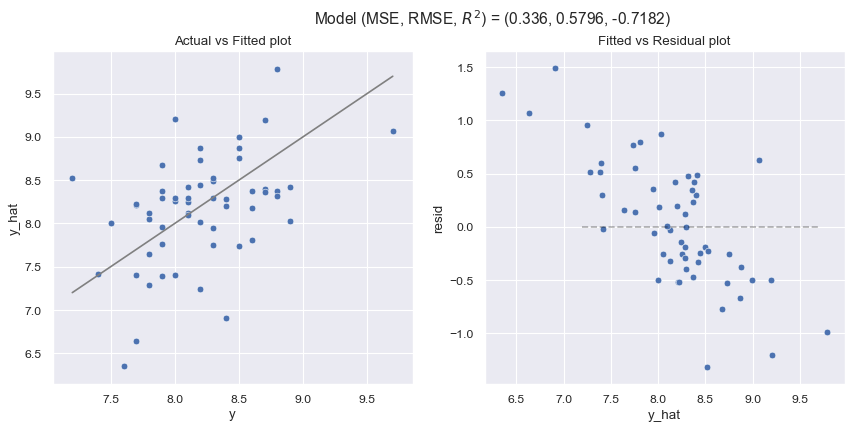

In [20]:
import warnings
warnings.filterwarnings('ignore')

model_pipeline = Pipeline([
    ('regressor', LinearRegression())
])


# Fitting the model
model_pipeline.fit(X_train, y_train)


mse, rmse, rsqr = model_fit(model_pipeline, X_test, y_test, plot=True)

Mean squared error: 0.3359611558874697
R-squared: -0.7181855295472941


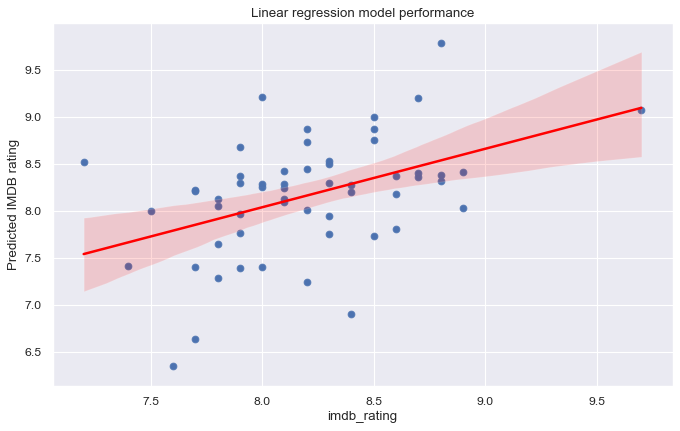

In [21]:
model_pipeline = Pipeline([
    ('regressor', LinearRegression())
])


# Fitting the model
model_pipeline.fit(X_train, y_train)

# Testing the model
y_predict = model_pipeline.predict(X_test)

# Printing performance metrics
print(f"Mean squared error: {mean_squared_error(y_test, y_predict)}")
print(f"R-squared: {r2_score(y_test, y_predict)}")

sns.scatterplot(x=y_test, y=y_predict)
plt.xlabel('Actual IMDB rating')
plt.ylabel('Predicted IMDB rating')
plt.title('Linear regression model performance')

sns.regplot(x=y_test, y=y_predict, line_kws={'color': 'red'})

plt.show()

### Ridge model

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

alphas = np.linspace(0, 200, num=200)
gs_ridg3 = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs_ridg3.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([  0.        ,   1.00502513,   2.01005025,   3.01507538,
         4.0201005 ,   5.02512563,   6.03015075,   7.03517588,
         8.04020101,   9.04522613,  10.05025126,  11.05527638,
        12.06030151,  13.06532663,  14.07035176,  15.0753768...
       172.86432161, 173.86934673, 174.87437186, 175.87939698,
       176.88442211, 177.88944724, 178.89447236, 179.89949749,
       180.90452261, 181.90954774, 182.91457286, 183.91959799,
       184.92462312, 185.92964824, 186.93467337, 187.93969849,
       188.94472362, 189.94974874, 190.95477387, 191.95979899,
       192.96482412, 193.96984925, 194.97487437, 195.9798995 ,
       196.98492462, 197.98994975, 198.99497487, 200.        ])},
             scoring='neg_root_mean_squared_error')

In [23]:
print(gs_ridg3.best_params_)

{'ridge__alpha': 102.51256281407035}


Mean squared error: 0.1179215427838536
Residual mean squared error: 0.34339706286433724
R-squared: 0.39692108780285884


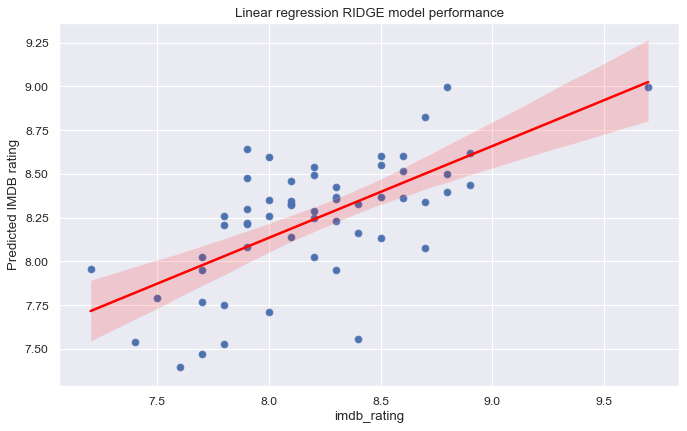

In [24]:
model_pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=102.5))
])


# Fitting the model
model_pipeline_ridge.fit(X_train, y_train)

# Testing the model
y_predict = model_pipeline_ridge.predict(X_test)

# Printing performance metrics
print(f"Mean squared error: {mean_squared_error(y_test, y_predict)}")
print (f"Residual mean squared error: {np.sqrt(mean_squared_error(y_test, y_predict))}")
print(f"R-squared: {r2_score(y_test, y_predict)}")

sns.scatterplot(x=y_test, y=y_predict)
plt.xlabel('Actual IMDB rating')
plt.ylabel('Predicted IMDB rating')
plt.title('Linear regression RIDGE model performance')

sns.regplot(x=y_test, y=y_predict, line_kws={'color': 'red'})

plt.show()

In [25]:
coeffients_series = pd.Series(get_coefs(model_pipeline_ridge), index=X_train.columns)

directors = data.filter(regex='^d_').columns.values
writers = data.filter(regex='^w_').columns.values
main_characters = data.filter(regex='^mc_').columns.values

def plot_coef_magnitude(coef_series, label):
    # sort the coefficients by magnitude in descending order
    sorted_coef = coef_series.abs().sort_values(ascending=False)

    # create a bar plot for the coefficients
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_coef.index, sorted_coef.values)
    plt.xticks(rotation=90)
    plt.xlabel(label)
    plt.ylabel('Coefficient')
    plt.title('Coefficient Magnitude ({})'.format(label))
    plt.show()

In [ ]:
X_t = X_test[['season', 'n_directions', 'n_words', 'n_speak_char', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode', 'month',]]
X = X_train[['season', 'n_directions', 'n_words', 'n_speak_char', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode', 'month',]]

alphas = np.linspace(0, 20, num=200)
gs_ridg3 = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs_ridg3.fit(X, y_train)

In [ ]:
print(gs_ridg3.best_params_)

In [ ]:
model_pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=15.88))
])


# Fitting the model
model_pipeline_ridge.fit(X, y_train)

# Testing the model
y_predict = model_pipeline_ridge.predict(X_t)

# Printing performance metrics
print(f"Mean squared error: {mean_squared_error(y_test, y_predict)}")
print (f"Residual mean squared error: {np.sqrt(mean_squared_error(y_test, y_predict))}")
print(f"R-squared: {r2_score(y_test, y_predict)}")

sns.scatterplot(x=y_test, y=y_predict)
plt.xlabel('Actual IMDB rating')
plt.ylabel('Predicted IMDB rating')
plt.title('Linear regression RIDGE model performance')

sns.regplot(x=y_test, y=y_predict, line_kws={'color': 'red'})

plt.show()

### Lasso model

In [ ]:
alphas = np.linspace(0, 200, num=200)
gs_lass0 = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Lasso()
    ),
    param_grid = {'lasso__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs_lass0.fit(X_train, y_train)

In [ ]:
print(gs_lass0.best_params_)

In [ ]:
model_pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=1))
])


# Fitting the model
model_pipeline_lasso.fit(X_train, y_train)

mse, rmse, rsqr = model_fit(model_pipeline_lasso, X_test, y_test, plot=True)

In [ ]:
X_t = X_test[['season', 'n_directions', 'n_words', 'n_speak_char', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode', 'month',]]
X = X_train[['season', 'n_directions', 'n_words', 'n_speak_char', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode', 'month',]]

alphas = np.linspace(0, 2, num=200)
gs_lass0 = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Lasso()
    ),
    param_grid = {'lasso__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs_lass0.fit(X, y_train)

In [ ]:
print(gs_lass0.best_params_)

In [ ]:
model_pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.02))
])


# Fitting the model
model_pipeline_lasso.fit(X, y_train)

mse, rmse, rsqr = model_fit(model_pipeline_lasso, X_t, y_test, plot=True)

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

#### Little comment:
For this section we could first comment on the coefficients of the finetuned model from section 3, with the optimal alpha, with the code below, and then support the findinds with the code that plots coefficients against a range of alphas. The plots will not be as crazy once we have decreased the number of directors, writers and rest of features (and maybe even main characters).

In [ ]:
directors = X_train.filter(regex='^d_').columns.values
writers = X_train.filter(regex='^w_').columns.values
main_characters = X_train.filter(regex='^mc_').columns.values
rest_of_features = [var for var in X_train.columns.values 
                if var not in np.concatenate((directors, writers, main_characters), axis=0)]

def plot_features_coef_magnitude_for_given_model(m, features, label, ax):
    # Getting the coefficients from the model and selecting subset
    # corresponding to features.
    coefs_series = pd.Series(get_coefs(m), index=X_train.columns)
    coefs_features = coefs_series.loc[features]
    
    # Sorting coefficients
    sorted_coef = coefs_features.abs().sort_values(ascending=False)

    # Plotting.
    ax.bar(sorted_coef.index, sorted_coef.values)
    ax.set_xticklabels(sorted_coef.index, rotation=90)
    ax.set_xlabel(label)
    ax.set_ylabel('Coefficient')
    ax.set_title('Coefficient Magnitude ({})'.format(label))

    
# test model for testing the function
m = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=15.88))
])

# Fitting the model
m.fit(X_train, y_train)

fig, axs = plt.subplots(2, 2, figsize=(17, 12))

plot_features_coef_magnitude_for_given_model(m, directors, "Directors", axs[0, 0])
plot_features_coef_magnitude_for_given_model(m, writers, "Writers", axs[0, 1])
plot_features_coef_magnitude_for_given_model(m, main_characters, "Main Characters", axs[1, 0])
plot_features_coef_magnitude_for_given_model(m, rest_of_features, "Rest of the features", axs[1, 1])

plt.tight_layout()
plt.show()

Code that works out the coefficients of the features specified in features for the given model (ridge or lasso) for a range of alphas, and plots the coefficients against the alphas.

In [ ]:
def coefs_vs_alpha(features, model_type):
    alphas = np.logspace(-2, 2, num=200) # from 10^-2 to 10^2
    
    # Arrays to store coefficients and rmses
    betas = [] 
    rmses = []

    for a in alphas:
        m = make_pipeline(
            StandardScaler(),
            model_type(alpha=a)
        ).fit(X_train, y_train)
        
        # Getting the coefficients for the specified features, and
        # getting rmses.
        coefs_series = pd.Series(get_coefs(m), index=X_train.columns)
        variables_coefs = coefs_series.loc[features]
        betas.append(variables_coefs)
        rmses.append(model_fit(m, X_test, y_test))
        
    # Createing DataFrame of coefficients and RMSEs
    res = pd.DataFrame(
        data=betas,
        columns=features,
    ).assign(
        alpha = alphas,
        rmse = rmses
    ).melt(
        id_vars = ('alpha', 'rmse')
    )
    
    # Plotting.
    sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
    plt.show()

    
coefs_vs_alpha(directors, Ridge)
coefs_vs_alpha(writers, Ridge)
coefs_vs_alpha(main_characters, Ridge)
coefs_vs_alpha(rest_of_features, Ridge)v

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from


* Evkaya, Ozan. 2023. The Office CSV Data File, MATH11205: Machine Learning in Python, The University of Edinburgh.
* Various authors. 2023a. List of Cold Opens, Dunderpedia: The Office Encylopedia. Accessed on 08/03/2023. URL: https://theoffice.fandom.com/wiki/List_of_Cold_Opens
* Various authors. 2023b. List of Jim's Pranks, Dunderpedia: The Office Encylopedia. Accessed on 06/03/2023. URL: https://theoffice.fandom.com/wiki/List_of_Jim%27s_pranks
* West, Kelly. 2020. The Office: Jim Halpert And Pam Beesly's Relationship Told In 45 Episodes, CinemaBlend. Accessed on 05/03/2023. URL: https://www.cinemablend.com/television/2487769/the-office-jim-halpert-and-pam-beeslys-relationship-episode-playlist